
# Lab 2 - Machine Learning

## About this lab

On this lab, we will try to understand how to build machine learning models for prediction tasks in biology. You will be asked to reflect on some core concepts of the methods and to write down your interpretations. It is important that you understand what you are doing, and thoughtful answers are expected.

For sections 1-5, only oral examination is required. Please fill in the form to get into the queue for examination: https://forms.gle/mVGriBerkTyzyVLT8. You can check the status of the queue here https://docs.google.com/spreadsheets/d/1oVaFBYUN8ZE_b0O32EmJ7WFlOTyvcF7Njuii6mWGm8s/edit?usp=sharing. While no written report is required, we recommend to take notes, especially on the tasks which require finding the best parameters and/or showing the results.

You will also be provided with some optional bonus questions that involve a little more research and programming on your part, but successful completion of those will award you extra points in the final examination. Bonus points are graded via oral examination, but we require you to send your notebooks with any new code you have written for documentation.

# Machine learning

Let's pick up from where we left in the last lab. By the end of the lab you found interesting genes that were **differentially expressed** between two **clinically relevant** conditions.

(Note: the selection of relevant clinical conditions is even more important in this lab, if you haven't spent some time on it previously, take the time now.)

You've also learned that one way to make more sense of these results is by creating **machine learning modells** to distinguish between different groups/conditions. Let's try that.

As always, we start by importing relevant libraries and loading the data.


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qvalue

from ipywidgets import interact, interact_manual
from ipywidgets import IntSlider, FloatSlider, Dropdown, Text
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

import sklearn as skl
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

interact_plot=interact_manual.options(manual_name="Plot")
interact_calc=interact_manual.options(manual_name="Calculate tests")

interact_gen=interact_manual.options(manual_name="Initialize data")
interact_SVM=interact_manual.options(manual_name="Train SVM")
interact_ANN=interact_manual.options(manual_name="Train ANN")

clinical_data = pd.read_csv('../data/brca_clin.tsv.gz', sep ='\t', index_col=2)
clinical_data = clinical_data.iloc[4:,1:]
expression_data = pd.read_csv('../data/brca.tsv.gz', sep ='\t', index_col=1)
expression_data = expression_data.iloc[:,2:].T


# 1 Support Vector Machine

We continue with our dataset on breast cancer and we will try to use machine learning to **predict the clinical conditions based on the gene expression data**.

You will be able two choose the two clinical groups we will use to train the model, and your choice will affect the results and performance of the model. Special attention should be paid to the number of data points in each group, which will be displayed after you select the groups.

Let's train our first SVM. You've learned the merits of feature scaling (or in other terms, normalizing the input), and so we will test it.
Below you will separate the data set into two, and train a SVM to distinguish between the two using the gene expression values of the samples. You can choose whether you'd like to rescale (normalize) the features first or not.

Once you have done so, you will be presented with a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), and from that will need to devise a performance metric.
[This Wikipedia page](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) can be helpful when choosing how to measure the performance. You might want to do that before running the SVM tests.

You know the drill by now, play around with it for a while and answer the questions.

Interactive fields:
* **Rescale**: whether to apply mean and variance normalization before training the SVM.
* **Data_split**: the fraction of the data that is left on the test set.
* **Max_iterations**: the maximum number of iterations the SVM is allowed to perform, increase it if you are seeing convergence errors.

## Questions


* 1.1 Which clinical groups have you decided to classify using SVMs? Why did you think these are the groups which could be classified using SVMs and gene expression data? Give 1-2 arguments to justify your choice.
* 1.2 Report the size of your two groups. Which performance metric did you choose? Give 1-2 arguments to justify your choice.
* 1.3 How much did you chose to leave out for the test set? Justify your choice as an optimal tradeoff between the performance of your classifier and your ability to measure that performance? (What would happen to the performance and your ability to measure it if you would exclude less/more data from the training?)
* 1.4 Did you achieve better performance by normalizing the gene expression? Provide 1-2 plausable reasons why the performance improved or did not improve.






In [2]:
def split_data(clinical_df, expression_df, separator, cond1, cond2):
    try:
        group1 = clinical_df[separator] == cond1
        index1 = clinical_df[group1].index
        group2 = clinical_df[separator] == cond2
        index2 = clinical_df[group2].index
    except:
        print('Clinical condition wrong')
    expression1 = expression_df.loc[index1].dropna()
    expression2 = expression_df.loc[index2].dropna()
    expression = pd.concat([expression1, expression2])
    X = expression.values
    y = np.append(np.repeat(0, len(expression1)), np.repeat(1, len(expression2)))
    display(pd.DataFrame([len(index1),len(index2)], columns = ['Number of points'], index = ['Group 1', 'Group 2']))
    return X, y

def train_SVM(X, y, C=1, scale = False, max_iter = 1000):
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    clf = LinearSVC(C=C, max_iter=max_iter)
    clf.fit(X,y)
    return clf

def print_accuracy(X_train, y_train, X_test, y_test, clf, scale=False):
    if scale:
        train_size = X_train.shape[0]
        scaler = StandardScaler()
        X = np.concatenate((X_train, X_test))
        X = scaler.fit_transform(X)
        X_train = X[:train_size,:]
        X_test = X[train_size:,:] 
    y_train_pred = clf.predict(X_train)
    ac_matrix_train = confusion_matrix(y_train, y_train_pred)
    y_test_pred = clf.predict(X_test)
    ac_matrix_test = confusion_matrix(y_test, y_test_pred)
    display(pd.DataFrame(np.concatenate((ac_matrix_train,ac_matrix_test), axis =1), columns = ["predicted G1 (training)","predicted G2 (training)", "predicted G1 (test)","predicted G2 (test)"],index=["actual G1","actual G2"]))
    
def plot_pca_variance(X, ncomp = 1, scale = False):
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    pca = PCA()
    pca.fit(X)
    plt.rcParams["figure.figsize"] = (20,10)
    sns.set(style='darkgrid', context='talk')
    plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    
    plt.vlines(ncomp, 0, plt.gca().get_ylim()[1], color='r', linestyles = 'dashed')
    h = np.cumsum(pca.explained_variance_ratio_)[ncomp -1]
    plt.hlines(h, 0, plt.gca().get_xlim()[1], color='r', linestyles = 'dashed')
    plt.title(str(ncomp) + ' components, ' + str(round(h, 3)) + ' variance explained')
    plt.show()
    
def reduce_data(X, n, scale = False):
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    pca = PCA(n_components=n)
    Xr = pca.fit_transform(X)
    return Xr

def interact_split_data(Criteria, Group_1, Group_2):
    global BRCA_X, BRCA_y
    BRCA_X, BRCA_y = split_data(clinical_data, expression_data, Criteria, Group_1, Group_2)

def interact_SVM_1(Rescale, Data_split, Max_iterations):
    X = BRCA_X
    max_iter = int(Max_iterations)
    X_train, X_test, y_train, y_test = train_test_split(BRCA_X, BRCA_y, test_size=Data_split)
    clf = train_SVM(X_train, y_train, C=1, scale = Rescale, max_iter=max_iter)
    print_accuracy(X_train, y_train, X_test, y_test, clf, scale = Rescale)
    
interact_gen(interact_split_data, Criteria=Text('Surgical procedure first'), Group_1 = Text('Simple Mastectomy'), Group_2=Text('Lumpectomy'))
interact_SVM(interact_SVM_1, Rescale = False, Data_split = FloatSlider(min=0,max=1,value=0.1, step = 0.05), Max_iterations = Text('1000'))

interactive(children=(Text(value='Surgical procedure first', description='Criteria'), Text(value='Simple Maste…

interactive(children=(Checkbox(value=False, description='Rescale'), FloatSlider(value=0.1, description='Data_s…

<function __main__.interact_SVM_1(Rescale, Data_split, Max_iterations)>

# 2 Regularization

You have learned about the propensity of machine learning methods to overfit.
One way of trying to avoid overfitting is called [**regularization**](https://en.wikipedia.org/wiki/Regularization_(mathematics)).
Regularization, as the names suggests, is a way of adding extra rules in a way that adds extra information on the model. It also serves as a great way to add **domain knowledge** into a general model.

SVMs have a built in regularization mechanism in the form of the **C parameter**. If you are not familiar with this parameter, read a bit on it, and then play around with the SVM below.
As with every form of regularization, it is more of an art than a science, and so a good value will depend a lot on how your data looks like.

New interactive fields:
* **C_parameter**: the value of the C parameter.

## Questions


* 2.1 What is the "extra rule" that regularization with C parameter adds to the algorithm?
* 2.2 How would the trust you can have in labelling used for training correspond to the value of the C parameter you would choose? Think of hard to clasify/borderline, and provide one hypothetical example when a high C value would be preferabele, and one when a low one would be better.
* 2.3 Did regularization with C parameter improve the performance of your predictor from part 3? Provide one reason why you think it was (not) so.
* 2.4 Maximizing the perfomance of the classifier is not always the best criterium for deciding whether to regularize or not. Provide one hypothetical example when you would set a C value based on **prior knowledge** rather than on **best performance**. Hint: consider the data available to you.

In [3]:
def interact_SVM_2(Rescale, Data_split, Max_iterations, C_parameter):
    max_iter = int(Max_iterations)
    C = float(C_parameter)
    X_train, X_test, y_train, y_test = train_test_split(BRCA_X, BRCA_y, test_size=Data_split)
    clf = train_SVM(X_train, y_train, C=C, scale = Rescale, max_iter=max_iter)
    print_accuracy(X_train, y_train, X_test, y_test, clf, scale = Rescale)

interact_gen(interact_split_data, Criteria=Text('Surgical procedure first'), Group_1 = Text('Simple Mastectomy'), Group_2=Text('Lumpectomy'))
interact_SVM(interact_SVM_2, Rescale = False, Data_split = FloatSlider(min=0,max=1,value=0.1, step = 0.05), Max_iterations = Text('1000'), C_parameter = Text('1'))

interactive(children=(Text(value='Surgical procedure first', description='Criteria'), Text(value='Simple Maste…

interactive(children=(Checkbox(value=False, description='Rescale'), FloatSlider(value=0.1, description='Data_s…

<function __main__.interact_SVM_2(Rescale, Data_split, Max_iterations, C_parameter)>

# 3 Dimensionality

Let's explore how the dimensionality of the data affects the prediction accuracy. You have heard of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) and, in bioinformatics, often we are subject to it just because of the amount of genes on a genome and the low number of samples.

Luckily, you have also learned at least one way to reduce the dimensionality of the data. Here we will use PCA to reduce the dimensions from around 20 thousand genes (dimensions) to a more manageable number of dimensions.
First, you will need to choose if you normalize all the dimensions before performing the PCA, then you will be shown how much of the variance in the data is captured by the first components (remember that the normalization also changes the variance). With this information you will be able to have an educated guess on how many principal components you want to use to train the SVM.

The core PCA algorithm, as such, does not reduce the number of dimensions. It levarages co-variation of different variables (in different dimensions) to capture as much of total variations in as few dimensions, i.e. principal components, as possible. In contrast to dimensionality reduction methods such as UMAP or tSNE, no information is lost. Thus, given the full output matrices from PCA, it should be possible to retrive original values (check Singular Value Decomposition, e.g. in the lecture about PCA, for more details). After the transformation, the samples should vary a lot across the first few components, and little across all the rest. 

In most cases, PCA is used to retrive only a few first principal components, most often just the first two. The idea is that the first components should correspond to meaningful variance, driven by the the same (biological) processes in multiple samples, thus leading to co-variation. The other components can be, for some purposes, disregarded as "noise". By picking only few first components, PCA can be used for dimensionality reduction. That is very useful for visualization, as one can often show in 2D most of the variation corresponding to effects of key factors structuring the data. Another application can be to reduce the number of dimensions to avoid the curse of dimensionality, e.g. to improve the performance of an SVM-based predictor. This is what we will try to do in this exercise.

As always, play with it as much as you need to answer the question.

New interactive fields:

* **PCA_scaling**: whether to apply the normalization before performing the PCA.
* **N_components**: number of principal components selected.
* **Reduce_dim**: whether to reduce the dimentions of the data before training the SVM.

## Questions

* 3.1 Explain one of the causes of **curse of dimensionality**. Why adding more information doesn't always increase the performance? It can be a characteristic of biological data/systems or a general property of the algorithms prone to the problem.
* 3.2 After performing PCA on our data, how much of the variance did the first two components explain? What was the minimal number of components which explained most of the variation?
* 3.3 Would you use the first two principal components to visualize the data? Give one reason why/why not.
* 3.4 Did the dimensionality reduction improve the perfomance of the predictor? Provide parameters you have used and give the one cause you find most probable/influencial to explain the fact the performance did/did not improve? Could you have predicted the outcome based on the answers to Q3.2 and the plot of explained variance vs the number of components?

interactive(children=(Text(value='ER Status By IHC', description='Criteria'), Text(value='Positive', descripti…

interactive(children=(Checkbox(value=False, description='PCA_scaling'), Text(value='1', description='N_compone…

interactive(children=(Checkbox(value=False, description='Rescale'), FloatSlider(value=0.1, description='Data_s…

<function __main__.interact_SVM_3(Rescale, Data_split, Max_iterations, C_parameter, Reduce_dim, PCA_scaling, N_components)>

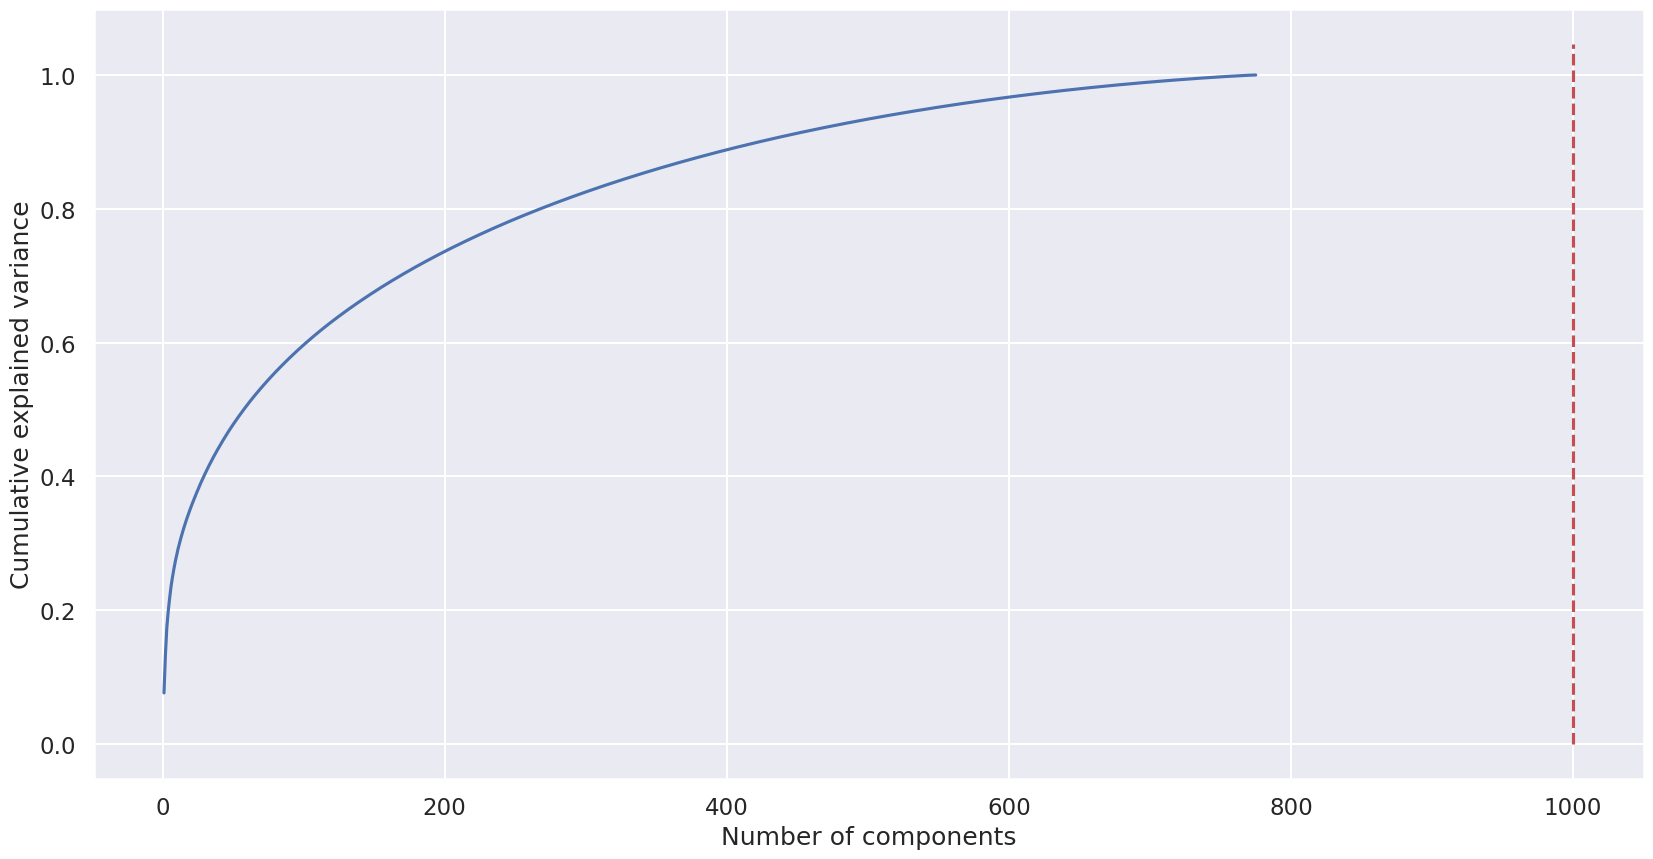

In [4]:
def interact_PCA_plot(PCA_scaling, N_components):
    n_comp = int(N_components)
    plot_pca_variance(BRCA_X, scale=PCA_scaling, ncomp = n_comp)
    
def interact_SVM_3(Rescale, Data_split, Max_iterations, C_parameter, Reduce_dim, PCA_scaling, N_components):
    max_iter = int(Max_iterations)
    n_comp = int(N_components)
    C = float(C_parameter)
    if Reduce_dim:
        X = reduce_data(BRCA_X, n = n_comp, scale=PCA_scaling)
    else:
        X = BRCA_X
    X_train, X_test, y_train, y_test = train_test_split(X, BRCA_y, test_size=Data_split)
    clf = train_SVM(X_train, y_train, C=C,  scale = Rescale, max_iter=max_iter)
    print_accuracy(X_train, y_train, X_test, y_test, clf,  scale = Rescale)
    
interact_gen(interact_split_data, Criteria=Text('ER Status By IHC'), Group_1 = Text('Positive'), Group_2=Text('Negative'))
interact_plot(interact_PCA_plot, PCA_scaling = False, N_components = Text('1'))
interact_SVM(interact_SVM_3, Rescale = False, Data_split = FloatSlider(min=0,max=1,value=0.1, step = 0.05), Max_iterations = Text('1000'), C_parameter = Text('1'), Reduce_dim = False, PCA_scaling = False, N_components = Text('1'))

# 4 Deep Artificial Neural Network: warmup

**Artifical Neural Networks (ANNs)** are a group of machine learning algorithms structured based on the same principles. The key components are **nodes**, organized into layers and connected between layers. Input nodes are input variables. Each of the other nodes corresponds to an artificial neuron. An artificial neuron is a function, usually taking multiple inputs with different weights. In the most simple version, it combines the weighted linear effect of the input. On top of that, there is usually an **activation function**, in most cases non-linear (the most popular one being [ReLU](https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning)). There is a threshold for the output of the activation function, below which the artificial neuron is not activated at all. If the threshold is not met, the value is somehow transformed (easiest examples are setting it to zero or multiplying by a constant). Both the weights and the threshold are optimized in the course of training.
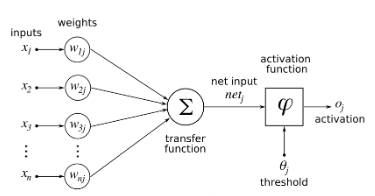

The network is organized in multiple **layers**. As mentioned above, the nodes in the first layer consist of input variables. Then come the hidden layers. Those are intermediate variables, allowing the network to recognize key features of the input data. However, the nodes in the hidden layer usually cannot be easily connected to specific properties of the studied system/input data. Thus, uncovering the properties of the original system which allow ANNs to make predictions can become an immensely hard task. Moreover, modern ANNs usually consist of multiple hidden layers. In this case, we talk about **deep learning**, the depth here being the number of layers. Ultimately, the last layer is an output layer, consisting of variable(s) that we want to predict.
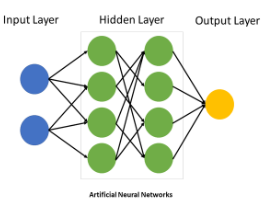

Let's first try to build a predictor for a simple, simulated two-dimensional dataset. We take two continuous input variables, and we divide the data into two groups which are to be predicted.

## Questions

* 4.1 How well does the model peform without an activity-function(non-linear)? Does it help to stack more layers or using more nodes without the activation function? Can you explain the observed behavior?
* 4.2 Does the model peform better with acitvation function? Can you observe any peformance increase with more layers/nodes why?

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def gen_data():
    N=2
    n = 100
    mA = [1, 0.3]
    sigmaA = 0.2
    mB = [0, -0.1]
    sigmaB = 0.3
    P = n * 2
    M = 1
    classA = np.ones((2, n))
    classB = np.ones((2, n))

    classA[0, :round(0.5* n)] = np.random.randn(1, round(0.5 * n)) * sigmaA - mA[0]
    classA[0, round(0.5* n):] = np.random.randn(1, round(0.5 * n)) * sigmaA + mA[0]
    classA[1, :] = np.random.randn(1, n) * sigmaA + mA[1]
    classB[0, :] = np.random.randn(1, n) * sigmaB + mB[0]
    classB[1, :] = np.random.randn(1, n) * sigmaB + mB[1]

    shuffling = np.array(range(0,200))
    np.random.shuffle(shuffling)
    # Plot the data
    plt.plot(classA[0, :], classA[1, :], 'b.')
    plt.plot(classB[0, :], classB[1, :], 'r.')
    plt.axis('equal')  # Force same scale on both axes
    plt.savefig('data.pdf')
    plt.show()

    target_vector = np.concatenate((np.ones((1, 100)), np.zeros((1, n))), axis=1)
    training_set = np.concatenate((classA, classB), axis=1)
    target_vector[0] = target_vector[0][shuffling]
    training_set[0,:] = training_set[0,:][shuffling]
    X_train = training_set.transpose()
    Y_train = target_vector[0]
    
    return X_train, Y_train

def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1

    # Create a meshgrid of points with distance h between them
    h = max((xmax-xmin)/steps, (ymax-ymin)/steps)
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h),
                         np.arange(ymin, ymax, h))

    # Predict the function value for the whole gid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=cmap)
    #plt X and color after y label 
    plt.scatter(X[:,0], X[:,1], c=y)

In [6]:
def genData(n = 100, mA = [1.0, 0.5], sigmaA = 0.5, mB = [-1.0, 0.0], sigmaB = 0.5):
    classA = np.vstack([np.concatenate((np.random.randn(1, round(0.5 * n)) * sigmaA - mA[0] ,np.random.randn(1, round(0.5 * n)) * sigmaA + mA[0]), axis=1), np.random.randn(1,n) * sigmaA + mA[1]])
    classB = np.vstack([np.random.randn(1,n) * sigmaB + mB[0], np.random.randn(1,n) * sigmaB + mB[1]])
    
    _ , n = classA.shape
    targetA = np.ones(n)
    targetB = -1 * np.ones(n)
    X = np.concatenate((classA, classB), axis=1).T
    y = np.concatenate((targetA, targetB))
    return X, y


In [7]:
X, y = genData(mA = [1.0, 0.3], sigmaA = 0.2, mB = [-0.0, -0.1], sigmaB = 0.3)


In [8]:
def interact_MLP(n_layers=1, n_nodes=10, acitvation=False):
    layers = (n_nodes for _ in range(n_layers))
    clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=layers, activation='relu' if acitvation else'identity')
    clf.fit(X, y)
    
    plot_decision_boundary(X, y, clf)
    

In [9]:
interact_ANN(interact_MLP, n_layers=(1,10,1), n_nodes=(1,100,1), acitvation=[False, True])

interactive(children=(IntSlider(value=1, description='n_layers', max=10, min=1), IntSlider(value=10, descripti…

<function __main__.interact_MLP(n_layers=1, n_nodes=10, acitvation=False)>

# 4 Deep Artificial Neural Network: Find smokers by vital signs

Now let's move to a real-life example. Here, we will try to build an ANN that can recognize smokers by the results of standard medical tests and basic contextual data (age, gender, etc), based on a [publicly available dataset](https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking/data).

We will divide the dataset into three subsets:
1. Training dataset - the data used for training of the neural network.
2. Validation dataset - a dataset to test the predictor while adjusting its (hyper-)parameters (e.g. number of layers and nodes.
3. Testing dataset - a dataset to test the performance of the final predictor.

Different metrics can be used to assess the performance of a machine learning predictor. Here we use accuracy, defined as the number of cases in which the prediction was correct divided by the total number of cases. Or, to describe it with a formula:
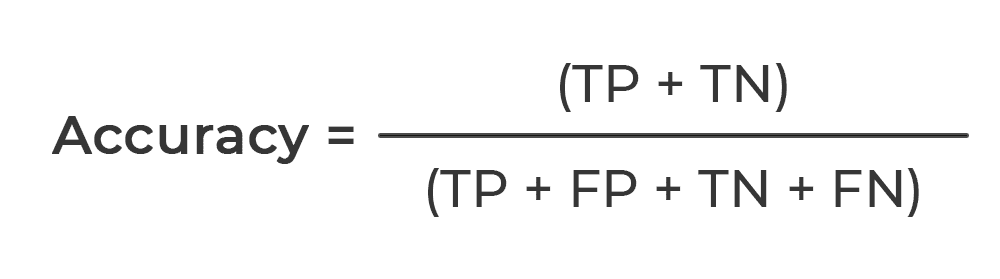


## Questions

* 4.3 We have dividied the data into train, validation, and test set. Why?
* 4.4 How well is peforming on the validation data compared to the training data based on the parameters: number of layers, nodes, epochs, and number of training samples. Save the paramters that performed the best in during validation.
* 4.5 Use the parameters that peformed the best on the test-data. How well is the accuracy on the testing dataset compared to the validation accuracy? Which one should be reported as the accuracy of the predictor.

In [10]:
import warnings

# Ignore a specific warning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
def get_smoker_data():
    smokers = pd.read_csv("smoking.csv")
    
    X, y = smokers[['gender','age', 'height(cm)', 'weight(kg)', 'waist(cm)',
       'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol',
       'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein',
       'serum creatinine', 'AST', 'ALT', 'Gtp',]].values, smokers.smoking.values
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    X_train, X_test, X_val = scaler.transform(X_train), scaler.transform(X_test), scaler.transform(X_val)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = get_smoker_data()

ValueError: could not convert string to float: 'M'

**Validation**

Here you compare the accuracy of your predictor on the data used for training, and a separated validation dataset. The goal is to find parameters that give you optimal parameters for the predictive model.

In [ ]:
def classify_smokers(n_layers=1, n_nodes=10, acitvation=False, n_samples=100, max_iter=10):
    layers = [n_nodes for _ in range(n_layers)]
    clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=layers, activation='relu' if acitvation else'identity', random_state=42, max_iter=max_iter)
    
    _X_train, _y_train = X_train[:n_samples], y_train[:n_samples]
    
    
    train_accuracies = []
    val_accuracies = []

    for i in range(clf.max_iter):
        clf.partial_fit(_X_train, _y_train, classes=np.array([0,1]))

        train_accuracy = clf.score(_X_train, _y_train)
        val_accuracy = clf.score(X_val, y_val)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, clf.max_iter + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, clf.max_iter + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
interact_ANN(classify_smokers, n_layers=(1,10,1), n_nodes=(1,100,1), acitvation=[False, True], n_samples=(100,10_000,100), max_iter=(10,1_000,10))

**Testing**

Here you compare the accuracy of your predictor on the data used for training, and a separated testing dataset.

In [ ]:
def classify_smokers_test(n_layers=1, n_nodes=10, acitvation=False, n_samples=100, max_iter=10):
    layers = [n_nodes for _ in range(n_layers)]
    clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=layers, activation='relu' if acitvation else'identity', random_state=42, max_iter=max_iter)
    
    _X_train, _y_train = X_train[:n_samples], y_train[:n_samples]
    
    
    train_accuracies = []
    test_accuracies = []

    for i in range(clf.max_iter):
        clf.partial_fit(_X_train, _y_train, classes=np.array([0,1]))

        train_accuracy = clf.score(_X_train, _y_train)
        test_accuracy = clf.score(X_test, y_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, clf.max_iter + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, clf.max_iter + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
interact_ANN(classify_smokers_test, n_layers=(1,10,1), n_nodes=(1,100,1), acitvation=[False, True], n_samples=(100,10_000,100), max_iter=(10,1_000,10))

# Bonus

**Note**: To get full points in the **bonus part** you only have to answer 3 out of the 4 questions below, but you **have to specify** on your report which question you are leaving out.

## Bias-variance trade-off

Bias and variance are both sources of error in any predictive model. The bias-variance trade-off principle states that usually models with high bias error have low variance error, and vice-versa.

* B1.1 Read more about **bias** and **variance**. Provide a one sentence explanation of each of the terms, in your own words.
* B1.2 Imagine a real-life example of a classifier. Explain what you would like to classify. Would high bias affect the perdictor's ability to infer the trait you are interested in for new data? (I.e. What kind of new datapoints/samples the predictor would be most likely to missclasify?) And how would it be affected by high variance.
* B1.3 Explain why there is a trade-off between bias and variance in context of complexity and overfitting of a model. Use figures if think it's useful.
* B1.4 Provide one way to control the trade-off in SVMs and one in clustering.


## Cross validation

Some times you don't have enough data, and it is a shame to leave some of it out of the training set. One way to mitigate this is by using cross validation.

* B2.1 Implement cross validation in one of the SVMs you used above. In how many parts you've divided your set? Why?
* B2.2 Compare the results above with the results from previous classifiers in this lab. Do you achieve better performance?

## Parameter optimization

For the questions below, we will explore more in depth how some parameter affect the performance by doing [parameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization).

Perform a parameter optimization, using cross validation, for the following parameter on an SVM you used above. You can use ready functions such as [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to help. Plot and interpret the results for optimizing:

* B3.1 Number of dimensions of the input (principal components)
* B3.2 The C parameter
* B3.3 The C parameter and number of dimensions, and scaling (of the input) at the same time.
* B3.4 Comment about the relationship between C parameter and number of dimensions by using the results above.
* B3.5 Now, investigate the claim that cross validation shouldn't be used to report performance. You may want to use [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1397873/) to do so. In your own words, provide one argument for using cross validation to report performance, one against, and state your opinion on the matter. (i.e. Would you use cross validation to report performance in your own research?)

## Extrapolating with artificial neural networks

In the example we used before, we sampled the training, validation, and testing dataset from the same larger dataset. Thus, the predictor was intrapolating, i.e. predicting within the variable space of the training dataset. This is best practice, but sometimes artificial intelligence models are used as best guesses in situations which go beyond the spectrum of training data. An example could be predicting structures of proteins based on metagenome-assembled genomes of uncultivated bacteria using AlphaFold. This is extratoplating.

Let's examine how our predictor from Q4.3-4.5 would work if we trained it on limited data, and then tried to extrapolate. What if we had training data only about male smokers, and tried to predict who is smoking among the females?

* B4.1 What are the dangers of extrapolating? Explain with your own words. Give at least two example of what could possibly go wrong.
* B4.2 Change the get_smoker_data() function so that the training and validation dataset come from male subjects, but testing dataset from female subjects.
* B4.3 How does the new predictor perform on the testing dataset? Is that what you expected?
* B4.4 Now let's also look if adding gender information would improve original prediction. Come back to sampling all three datasets (training, validation, testing) and add gender to the parameters you are using. Then retrain the ANN using (hyper)parametrs obtained from validation for Q4.4. Compare the testing results from the test performed for Q4.5 and here for the test without the gender column.
